In [ ]:
%cd /home/ubuntu/Qwen-Image-Edit-Angles

In [ ]:
import torch
from qwenimage.debug import clear_cuda_memory, print_gpu_memory
from qwenimage.experiment import ExperimentConfig
from qwenimage.experiments.experiments_qwen import PipeInputs, Qwen_AoT, QwenBaseExperiment, ExperimentRegistry

from qwenimage.debug import ctimed, ftimed, print_first_param
from qwenimage.models.attention_processors import QwenDoubleStreamAttnProcessorFA3, QwenDoubleStreamAttnProcessorSageAttn2, sageattn_qk_int8_pv_fp16_cuda_wrapper, sageattn_qk_int8_pv_fp16_triton_wrapper, sageattn_qk_int8_pv_fp8_cuda_sm90_wrapper, sageattn_qk_int8_pv_fp8_cuda_wrapper, sageattn_wrapper
from qwenimage.models.first_block_cache import apply_cache_on_pipe
from qwenimage.models.pipeline_qwenimage_edit_plus import QwenImageEditPlusPipeline, calculate_dimensions
from qwenimage.models.transformer_qwenimage import QwenImageTransformer2DModel
from qwenimage.experiment import AbstractExperiment, ExperimentConfig
from qwenimage.debug import ProfileSession, ftimed
from qwenimage.optimization import INDUCTOR_CONFIGS, TRANSFORMER_DYNAMIC_SHAPES, aoti_apply, drain_module_parameters, optimize_pipeline_
from qwenimage.prompt import build_camera_prompt


In [ ]:
name = "qwen_base"

experiment = ExperimentRegistry.get(name)(
    config=ExperimentConfig(
        name=name,
    ), 
)
experiment.load()


In [ ]:
# experiment.pipe.transformer

In [ ]:
experiment.pipe.transformer.fuse_qkv_projections()

In [ ]:
experiment.pipe.transformer.transformer_blocks[0].attn.fuse_projections()

In [ ]:
print(experiment.pipe.transformer.transformer_blocks[0].attn.fused_projections)
experiment.pipe.transformer.transformer_blocks[0].attn

In [ ]:
print(experiment.pipe.transformer.transformer_blocks[1].attn.fused_projections)
experiment.pipe.transformer.transformer_blocks[1].attn

In [ ]:
print([b.attn.fused_projections for b in experiment.pipe.transformer.transformer_blocks])

In [ ]:
for module in experiment.pipe.transformer.modules():
    print(module.__class__)
    # if isinstance(module, AttentionModuleMixin):
    #     module.fuse_projections()

In [ ]:
experiment.pipe.transformer.transformer_blocks[0].attn.processor

In [ ]:
experiment.pipe.transformer.transformer_blocks[0].attn.processor

In [ ]:
experiment.pipe.transformer.transformer_blocks[0].attn.processor.fuse_projections()

In [ ]:
experiment.pipe.transformer.transformer_blocks[0].attn.fuse_projections()

In [ ]:
experiment.pipe.transformer.transformer_blocks[0].attn

In [ ]:
experiment.pipe.transformer.transformer_blocks[0].attn.to_qkv.weight

In [ ]:
experiment.pipe.transformer.transformer_blocks[0].attn.to_q.weight

In [ ]:
experiment.pipe.transformer.transformer_blocks[0].attn.add_q_proj.weight

In [ ]:
experiment.pipe.transformer.transformer_blocks[0].attn.to_added_qkv.weight

In [ ]:
experiment.pipe.scheduler

In [ ]:

import math
from diffusers.schedulers.scheduling_flow_match_euler_discrete import FlowMatchEulerDiscreteScheduler
import torch

from qwenimage.models.pipeline_qwenimage_edit_plus import QwenImageEditPlusPipeline
from qwenimage.models.transformer_qwenimage import QwenImageTransformer2DModel

# Scheduler configuration for Lightning
scheduler_config = {
    "base_image_seq_len": 256,
    "base_shift": math.log(3),  # We use shift=3 in distillation
    "invert_sigmas": False,
    "max_image_seq_len": 8192,
    "max_shift": math.log(3),  # We use shift=3 in distillation
    "num_train_timesteps": 1000,
    "shift": 1.0,
    "shift_terminal": None,  # set shift_terminal to None
    "stochastic_sampling": False,
    "time_shift_type": "exponential",
    "use_beta_sigmas": False,
    "use_dynamic_shifting": True,
    "use_exponential_sigmas": False,
    "use_karras_sigmas": False,
}

# Initialize scheduler with Lightning config

scheduler = FlowMatchEulerDiscreteScheduler.from_config(scheduler_config) # TODO: check scheduler sync issue mentioned by https://pytorch.org/blog/presenting-flux-fast-making-flux-go-brrr-on-h100s/

dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "cpu"


pipe = QwenImageEditPlusPipeline.from_pretrained(
    "Qwen/Qwen-Image-Edit-2509", 
    transformer=QwenImageTransformer2DModel.from_pretrained( # TODO: remove this if using lightning
        "linoyts/Qwen-Image-Edit-Rapid-AIO", 
        subfolder='transformer',
        torch_dtype=dtype,
        device_map='cuda'),
    scheduler=scheduler,
    torch_dtype=dtype,
).to(device)

In [ ]:
import torch

e = torch.rand((1, 253, 3584), dtype=torch.bfloat16)
e.numel() * e.element_size() / (1024 ** 2)

In [ ]:
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"experiment load cuda: {torch.cuda.is_available()=}")

pipe = QwenImageEditPlusPipeline.from_pretrained(
    "Qwen/Qwen-Image-Edit-2509", 
    transformer=QwenImageTransformer2DModel.from_pretrained( # use our own model
        "Qwen/Qwen-Image-Edit-2509",
        subfolder='transformer',
        torch_dtype=dtype,
        device_map=device
    ),
    torch_dtype=dtype,
).to(device)

In [ ]:
pipe.scheduler

In [ ]:
from qwenimage.models.pipeline_qwenimage_edit_plus import retrieve_timesteps, calculate_shift
import numpy as np

num_inference_steps = 10

sigmas = np.linspace(1.0, 1 / num_inference_steps, num_inference_steps)
# image_seq_len = latents.shape[1]
image_seq_len = 4096
mu = calculate_shift(
    image_seq_len,
    pipe.scheduler.config.get("base_image_seq_len", 256),
    pipe.scheduler.config.get("max_image_seq_len", 4096),
    pipe.scheduler.config.get("base_shift", 0.5),
    pipe.scheduler.config.get("max_shift", 1.15),
)
timesteps, num_inference_steps = retrieve_timesteps(
    pipe.scheduler,
    num_inference_steps,
    device,
    sigmas=sigmas,
    mu=mu,
)

In [ ]:
timesteps

In [ ]:
from matplotlib import pyplot as plt

plt.plot(timesteps.float().cpu().numpy())

In [ ]:
num_inference_steps

In [ ]:
from qwenimage.models.pipeline_qwenimage_edit_plus import retrieve_timesteps


retrieve_timesteps(pipe.scheduler, num_inference_steps=num_inference_steps)

In [ ]:
pipe.to("cpu")

In [ ]:
from qwenimage.debug import clear_cuda_memory

In [ ]:
clear_cuda_memory()

In [ ]:
pipe.transformer.to("cuda")

In [ ]:
inps = PipeInputs()

In [ ]:
pipe(**inps[0])

In [ ]:
pipe.transformer.__class__.__module__

In [ ]:
pipe.transformer.__class__.__name__

In [ ]:
# pipe.transformer.__class__ = QwenImageTransformer2DModel


In [ ]:
pipe._internal_dict

In [ ]:
pipe._internal_dict["transformer"]

In [1]:
%cd /home/ubuntu/Qwen-Image-Edit-Angles

/home/ubuntu/Qwen-Image-Edit-Angles


In [2]:
from qwenimage.foundation import QwenImageFoundation
from qwenimage.datamodels import QwenInputs, QwenConfig
from qwenimage.experiments.experiments_qwen import PipeInputs
from qwenimage.models.pipeline_qwenimage_edit_plus import QwenImageEditPlusPipeline, calculate_dimensions

/usr/lib/python3/dist-packages/sklearn/utils/fixes.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
2025-11-23 08:38:00.662486: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-23 08:38:00.676959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763887080.694448 2395032 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/home/ubuntu/.local/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.12) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Skipping import of cpp extensions due to incompatible torch version 2.9.1+cu128 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info
TMA benchmarks will be running without grid constant TMA descriptor.
ERROR:bitsandbytes.cextension:Could not load bitsandbytes native library: /lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.32' not found (required by /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so)
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py", line 85, in <module>
    lib = get_native_library()
  File "/usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py", line 72, in get_native_library
    dll = ct.cdll.LoadLibrary(str(binary_path))
  File "/usr/lib/python3.10/ctypes/__init__.py", line 452, in LoadLibrary
    return self._dlltype(name)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._ha

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:


foundation = QwenImageFoundation(QwenConfig(
    # quantize_text_encoder=True,
    # quantize_transformer=True,
    # offload=False,
))

self.device='cuda'


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
from qwenimage.debug import ftimed,print_first_param
from torchao.utils import get_model_size_in_bytes

print(f"foundation.transformer size: {get_model_size_in_bytes(foundation.transformer) / 1024 / 1024} MB")

foundation.transformer size: 19542.183349609375 MB


In [7]:
from qwenimage.debug import clear_cuda_memory

clear_cuda_memory()


In [12]:
from qwenimage.finetuner import QwenLoraFinetuner

finetuner = QwenLoraFinetuner(foundation, foundation.config)
finetuner.load(None)

Loading Lora from None


In [25]:
from torch.nn import ModuleDict
for n,m in foundation.transformer.named_modules():
    # print(n, m)
    if n.endswith("_A") or n.endswith("_B"):
        if isinstance(m, ModuleDict):
            print(m["default"].weight.dtype)
    

torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bfloat16
torch.bflo

In [26]:
print([p.dtype for p in foundation.transformer.parameters()])

[torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.bfloat16, torch.b

In [6]:
from wandml.finetune.lora.lora import LoraFinetuner

foundation.transformer.fuse_qkv_projections()

LoraFinetuner.find_target_modules(foundation.transformer)

override


['to_k',
 'proj_out',
 'linear_2',
 'add_q_proj',
 'net.2',
 'to_added_qkv',
 'linear',
 'to_q',
 'to_v',
 'add_v_proj',
 'img_in',
 'to_add_out',
 'linear_1',
 'txt_in',
 'to_qkv',
 'proj',
 'img_mod.1',
 'txt_mod.1',
 'add_k_proj',
 'to_out.0']

In [4]:


inps = PipeInputs()
im = inps[0]["image"][0]

im = im.resize(calculate_dimensions(1024**2, im.width / im.height))

720 input combinations


In [13]:
im.size

(1248, 832)

In [5]:
# foundation.pipe.vae.to(foundation.dtype)

In [ ]:
latents = foundation.pil_to_latents(im)


In [12]:
latents.shape

torch.Size([1, 16, 1, 104, 156])

In [7]:
images = foundation.latents_to_pil(latents)

In [8]:
type(im), type(images[0])

(PIL.Image.Image, PIL.Image.Image)

In [9]:
import torch.nn.functional as F
import torchvision.transforms.v2 as T
import torch

_transforms = T.Compose([
    T.ToImage(),
    T.RGB(),
    T.ToDtype(torch.float32, scale=True), # [0,1]
    # T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # [-1,1]
])

F.mse_loss(_transforms(im), _transforms(images[0]))

tensor(2.1797e-05)

In [10]:
foundation.dtype

torch.bfloat16

Time taken by text_encoder.cuda(): 0.005439766915515065 seconds
Time taken by Preprocessing: 0.028795487945899367 seconds
_get_qwen_prompt_embeds, image
[<PIL.Image.Image image mode=RGB size=480x320 at 0x78167C64CE20>]
{'input_ids': tensor([[151644,   8948,    198,  74785,    279,   1376,   4419,    315,    279,
           1946,   2168,    320,   3423,     11,   6083,     11,   1379,     11,
          10434,     11,   6171,     11,   4004,    701,   1221,  10339,   1246,
            279,   1196,    594,   1467,   7600,   1265,  11596,    476,   5602,
            279,   2168,     13,  19813,    264,    501,   2168,    429,  20027,
            279,   1196,    594,   8502,   1393,  20337,  28137,    448,    279,
           4024,   1946,   1380,   8311,     13, 151645,    198, 151644,    872,
            198,  24669,    220,     16,     25,    220, 151652, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 15165

encode_prompt, prompt_embeds
Shape: (1, 253, 3584)
Min: -167.0, Max: 126.0, Mean: -0.1279296875
Device: cuda:0, Dtype: torch.bfloat16, Requires Grad: False
Time taken by QwenImageEditPlusPipeline.encode_prompt: 0.6033668370218948 seconds
Time taken by Encode Prompt: 0.6034080770332366 seconds
_encode_vae_image, image
Shape: (1, 3, 1, 416, 640)
Min: -1.0, Max: 1.0, Mean: -0.50390625
Device: cuda:0, Dtype: torch.bfloat16, Requires Grad: False
_encode_vae_image, image_latents
Shape: (1, 16, 1, 52, 80)
Min: -1.734375, Max: 1.796875, Mean: -0.04541015625
Device: cuda:0, Dtype: torch.bfloat16, Requires Grad: False
Time taken by QwenImageEditPlusPipeline._encode_vae_image: 0.22572305297944695 seconds
image_seq_len=4056
mu=0.6915322580645161
timesteps=tensor([1000.0000,  980.8338,  960.9587,  940.3351,  918.9197,  896.6658,
         873.5234,  849.4380,  824.3512,  798.1988,  770.9116,  742.4141,
         712.6240,  681.4511,  648.7971,  614.5536,  578.6018,  540.8107,
         501.0352,  459.

  0%|          | 0/28 [00:00<?, ?it/s]

Time taken by loop 0: 0.2955195050453767 seconds
Time taken by loop 1: 0.22209077689331025 seconds
Time taken by loop 2: 0.2558189689880237 seconds
Time taken by loop 3: 0.25663026107940823 seconds
Time taken by loop 4: 0.25767213897779584 seconds
Time taken by loop 5: 0.2572575770318508 seconds
Time taken by loop 6: 0.25672737695276737 seconds
Time taken by loop 7: 0.2565476590534672 seconds
Time taken by loop 8: 0.25710647902451456 seconds
Time taken by loop 9: 0.25823196792043746 seconds
Time taken by loop 10: 0.2575554469367489 seconds
Time taken by loop 11: 0.25711161689832807 seconds
Time taken by loop 12: 0.25672807497903705 seconds
Time taken by loop 13: 0.2572074339259416 seconds
Time taken by loop 14: 0.2569913560291752 seconds
Time taken by loop 15: 0.25719879497773945 seconds
Time taken by loop 16: 0.25799967907369137 seconds
Time taken by loop 17: 0.25743036391213536 seconds
Time taken by loop 18: 0.2582161040045321 seconds
Time taken by loop 19: 0.257111466024071 seconds


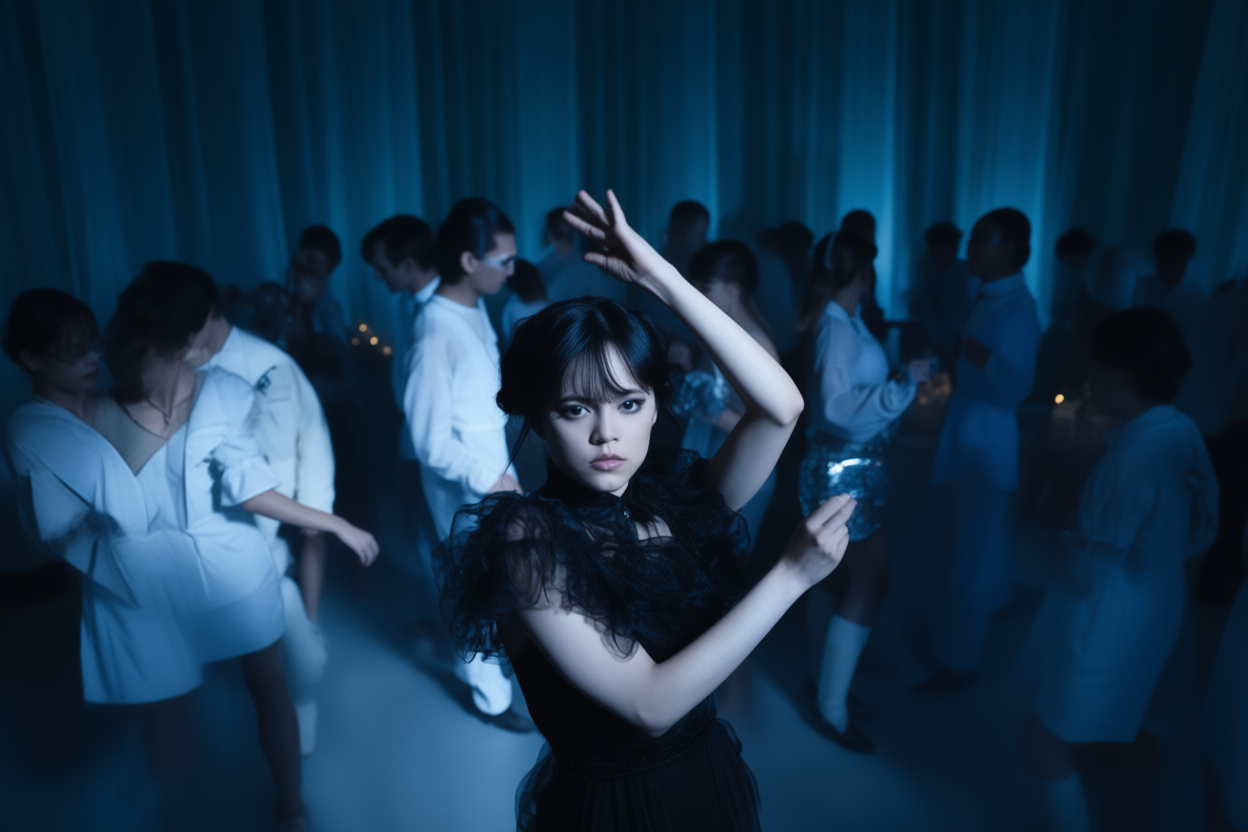

In [5]:
inps = QwenInputs(**inps[0])
inps.num_inference_steps = 28
outs = foundation.base_pipe(inps)
outs[0]

In [ ]:
import torch 

im_px = foundation.pipe.image_processor.preprocess(im).unsqueeze(2).to(dtype=torch.bfloat16)
im_px.shape

In [ ]:
foundation.pipe.vae.to(torch.bfloat16)

In [ ]:
latents = foundation.pipe.vae.encode(im_px).latent_dist.mode()
latents.shape

In [14]:
foundation.scheduler

FlowMatchEulerDiscreteScheduler {
  "_class_name": "FlowMatchEulerDiscreteScheduler",
  "_diffusers_version": "0.36.0.dev0",
  "base_image_seq_len": 256,
  "base_shift": 0.5,
  "invert_sigmas": false,
  "max_image_seq_len": 8192,
  "max_shift": 0.9,
  "num_train_timesteps": 1000,
  "shift": 1.0,
  "shift_terminal": 0.02,
  "stochastic_sampling": false,
  "time_shift_type": "exponential",
  "use_beta_sigmas": false,
  "use_dynamic_shifting": true,
  "use_exponential_sigmas": false,
  "use_karras_sigmas": false
}